# Effects Of Space Weather 
## MSDS 696 Practicum II 
#### Regis University 
#### Heather Holcomb 

#### How does the Ap - Planetary Equivalent Amplitude effect climate? 

In [65]:
# Load necessary libraries 
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
import netCDF4
import seaborn as sns
import numpy as np 
import statsmodels.formula.api as smf
import statsmodels.api
import fbprophet
import random

from netCDF4 import Dataset
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Load/Clean Space Weather Data

In [66]:
dfSpaceWeather = pd.read_csv('Data\SpaceWeatherData_Cleaned', header = 0, delimiter=r"\s+")
dfSpaceWeather.columns

Index(['yy', 'mm', 'dd', 'BSRN', 'ND', 'Kp', 'Kp.1', 'Kp.2', 'Kp.3', 'Kp.4',
       'Kp.5', 'Kp.6', 'Kp.7', 'Sum', 'Ap', 'Ap.1', 'Ap.2', 'Ap.3', 'Ap.4',
       'Ap.5', 'Ap.6', 'Ap.7', 'Avg', 'Cp', 'C9', 'ISN', 'F10.7', 'Q', 'Ctr81',
       'Lst81', 'F10.7.1', 'Ctr81.1', 'Lst81.1'],
      dtype='object')

In [67]:
#Rename columns to make sense 
dfSpaceWeather = dfSpaceWeather.rename(columns={
    "yy": "Year", 
    "mm": "Month", 
    "dd": "Day", 
    "BSRN": "BartelsSolarRotationNumber", 
    "ND": "NumberofDaywithintheBartels", 
    "Kp": "Kp_0000_0300", 
    "Kp.1": "Kp_0300_0600", 
    "Kp.2": "Kp_0600_0900", 
    "Kp.3": "Kp_0900_1200", 
    "Kp.4": "Kp_1200_1500",
    "Kp.5": "Kp_1500_1800",
    "Kp.6": "Kp_1800_2100",
    "Kp.7": "Kp_2100_0000",
    "Sum": "SumOfKps", 
    "Ap": "PlanetaryEquivalentAmplitude_0000_0300",
    "Ap.1": "PlanetaryEquivalentAmplitude_0300_0600",
    "Ap.2": "PlanetaryEquivalentAmplitude_0600_0900",
    "Ap.3": "PlanetaryEquivalentAmplitude_0900_1200",
    "Ap.4": "PlanetaryEquivalentAmplitude_1200_1500",
    "Ap.5": "PlanetaryEquivalentAmplitude_1500_1800",
    "Ap.6": "PlanetaryEquivalentAmplitude_1800_2100",
    "Ap.7": "PlanetaryEquivalentAmplitude_2100_0000",
    "Avg": "ArithmeticAverageof8Ap",
    "Cp": "PlanetaryDailyCharacterFigure", 
    "C9": "CpConversion", 
    "ISN": "InternationalSunspotNumber",
    "F10.7": "F10_7",
    "Q": "FluxQualifier",
    "Ctr81": "Centered81_dayArithmeticAverageofF10_7",
    "Lst81": "Last81DayArithmeticAverageofF10_7", 
    "F10.7.1": "ObservedValueOfF10_7",
    "Ctr81.1": "Centered81DayArithmeticAverageOfF10_7",
    "Lst81.1": "Last81DayArithmeticAverageOfF10_7"})

In [68]:
spaceWeather_dict = dfSpaceWeather.groupby(['Year','Month']).agg({
    'SumOfKps': 'mean',
    'ArithmeticAverageof8Ap': 'mean',
    'PlanetaryDailyCharacterFigure': 'mean',
    'NumberofDaywithintheBartels' : 'mean',
    'PlanetaryDailyCharacterFigure' : 'mean',
    'CpConversion' : 'mean',
    'InternationalSunspotNumber' : 'mean',
    'F10_7' : 'mean',
    'FluxQualifier' : 'mean',
    'Centered81_dayArithmeticAverageofF10_7' : 'mean',
    'Last81DayArithmeticAverageofF10_7' : 'mean',
    'ObservedValueOfF10_7' : 'mean',
    'Centered81DayArithmeticAverageOfF10_7' : 'mean',
    'Last81DayArithmeticAverageOfF10_7' : 'mean'
})
spaceWeather_dict

SumOfKps  ArithmeticAverageof8Ap  PlanetaryDailyCharacterFigure  \
Year Month                                                                      
1957 10     198.612903               13.774194                       0.683871   
     11     223.766667               18.033333                       0.810000   
     12     232.483871               17.741935                       0.841935   
1958 1      208.387097               14.741935                       0.738710   
     2      265.642857               26.857143                       0.978571   
...                ...                     ...                            ...   
2019 11      79.333333                4.200000                       0.156667   
     12      67.419355                3.064516                       1.870968   
2020 1       98.709677                4.806452                       5.935484   
     2      126.206897                6.413793                       0.379310   
     3      107.636364                4.818182                      15.181818   

            NumberofDaywithintheBartels  CpConversion  \
Year Month                                              
1957 10                       14.838710      3.225806   
     11                       15.000000      3.700000   
     12                       14.000000      3.903226   
1958 1                        12.774194      3.354839   
     2                        13.750000      4.500000   
...                                 ...           ...   
2019 11                       14.200000      0.566667   
     12                       14.709677     70.967742   
2020 1                        15.225806     72.322581   
     2                        14.862069     71.034483   
     3                         6.000000     57.181818   

            InternationalSunspotNumber       F10_7  FluxQualifier  \
Year Month                                                          
1957 10                     253.806452  281.225806       0.000000   
     11                     210.866667  256.100000       0.000000   
     12                     239.419355  284.322581       0.129032   
1958 1                      202.451613  247.870968       0.000000   
     2                      164.928571  209.857143       0.142857   
...                                ...         ...            ...   
2019 11                       0.500000   68.663333       0.000000   
     12                       0.000000   70.593548      68.380645   
2020 1                        0.000000   71.490323      70.090323   
     2                        0.000000   71.275862      71.362069   
     3                       12.909091   71.163636      71.581818   

            Centered81_dayArithmeticAverageofF10_7  \
Year Month                                           
1957 10                                 269.212903   
     11                                 270.756667   
     12                                 268.045161   
1958 1                                  251.338710   
     2                                  233.932143   
...                                            ...   
2019 11                                  68.796667   
     12                                  73.248387   
2020 1                                   74.709677   
     2                                   72.800000   
     3                                   71.172727   

            Last81DayArithmeticAverageofF10_7  ObservedValueOfF10_7  \
Year Month                                                            
1957 10                            241.138710            283.109677   
     11                            266.740000            259.216667   
     12                            269.800000            289.358065   
1958 1                             271.277419            251.506452   
     2                             257.303571            211.796429   
...                                       ...                   ...   
2019 11                             68.026667    

In [69]:
dfSpaceWeatherAverage = pd.DataFrame(spaceWeather_dict)

In [70]:
#Because my Climate Data goes from 2000-2019, i need to further subset my space weather data for the same date ranges 
isGT2000 = dfSpaceWeather['Year'] >= 2000
dfSpaceWeather = dfSpaceWeather[isGT2000]
isLT2020 = dfSpaceWeather['Year'] < 2020
dfSpaceWeather = dfSpaceWeather[isLT2020]
dfSpaceWeather

,Year,Month,Day,BartelsSolarRotationNumber,NumberofDaywithintheBartels,Kp_0000_0300,Kp_0300_0600,Kp_0600_0900,Kp_0900_1200,Kp_1200_1500,...,PlanetaryDailyCharacterFigure,CpConversion,InternationalSunspotNumber,F10_7,FluxQualifier,Centered81_dayArithmeticAverageofF10_7,Last81DayArithmeticAverageofF10_7,ObservedValueOfF10_7,Centered81DayArithmeticAverageOfF10_7,Last81DayArithmeticAverageOfF10_7
15432,2000,1,1,2272,7,53,47,40,33,43,...,1.3,6.0,48.0,125.6,0.0,160.5,175.0,129.9,165.6,179.0
15433,2000,1,2,2272,8,30,33,33,33,27,...,0.9,4.0,51.0,128.5,0.0,160.3,174.2,132.9,165.3,178.3
15434,2000,1,3,2272,9,33,30,27,27,23,...,0.7,3.0,54.0,128.7,0.0,160.0,173.3,133.1,165.0,177.4
15435,2000,1,4,2272,10,23,23,23,30,33,...,0.7,3.0,64.0,130.3,0.0,159.7,172.5,134.7,164.7,176.7
15436,2000,1,5,2272,11,40,33,33,33,23,...,1.0,5.0,73.0,132.0,0.0,159.4,171.8,136.5,164.4,176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22732,2019,12,27,2542,17,10,10,10,10,0,...,0.0,72.0,0.0,71.1,68.8,74.4,73.3,70.3,NaN,NaN
22733,2019,12,28,2542,18,10,0,0,0,0,...,0.0,72.0,0.0,71.1,68.9,74.5,73.3,70.4,NaN,NaN
22734,2019,12,29,2542,19,0,0,0,0,0,...,0.0,72.0,0.0,71.1,68.9,74.5,73.4,70.5,NaN,NaN
22735,2019,12,30,2542,20,10,10,0,10,0,...,0.0,71.0,0.0,71.2,69.0,73.4,73.4,70.5,NaN,NaN


In [71]:
dfSpaceWeather['Year'].astype('int64')
dfSpaceWeather['Month'].astype('int64')
spaceWeather_Averages = dfSpaceWeather.groupby(['Year','Month']).agg({
    'SumOfKps': 'mean',
    'F10_7' : 'mean',
    'FluxQualifier' : 'mean',
    'Centered81_dayArithmeticAverageofF10_7' : 'mean',
    'Last81DayArithmeticAverageofF10_7' : 'mean', 
    'ObservedValueOfF10_7' : 'mean',
    'Centered81DayArithmeticAverageOfF10_7' : 'mean',
    'Last81DayArithmeticAverageOfF10_7' : 'mean',
    'ArithmeticAverageof8Ap' : 'mean', 
    'PlanetaryDailyCharacterFigure' : 'mean', 
    'InternationalSunspotNumber' : 'mean'
})
spaceWeather_Averages

SumOfKps       F10_7  FluxQualifier  \
Year Month                                          
2000 1      187.645161  153.067742       0.064516   
     2      205.689655  169.117241       0.068966   
     3      145.322581  206.119355       0.000000   
     4      190.033333  185.490000       0.000000   
     5      196.741935  188.725806       0.064516   
...                ...         ...            ...   
2019 8      109.258065   68.661290       0.000000   
     9      151.633333   68.803333       0.000000   
     10     126.032258   67.009677       0.000000   
     11      79.333333   68.663333       0.000000   
     12      67.419355   70.593548      68.380645   

            Centered81_dayArithmeticAverageofF10_7  \
Year Month                                           
2000 1                                  162.309677   
     2                                  175.689655   
     3                                  187.287097   
     4                                  192.420000   
     5                                  186.835484   
...                                            ...   
2019 8                                   68.987097   
     9                                   68.200000   
     10                                  68.029032   
     11                                  68.796667   
     12                                  73.248387   

            Last81DayArithmeticAverageofF10_7  ObservedValueOfF10_7  \
Year Month                                                            
2000 1                             171.774194            158.132258   
     2                             160.893103            173.241379   
     3                             170.693548            208.154839   
     4                             184.963333            184.163333   
     5                             191.977419            184.529032   
...                                       ...                   ...   
2019 8                              69.619355             66.974194   
     9                              69.096667             68.063333   
     10                             68.448387             67.429032   
     11                             68.026667             70.183333   
     12                             72.683871             69.506452   

            Centered81DayArithmeticAverageOfF10_7  \
Year Month                                          
2000 1                                 167.190323   
     2                                 179.472414   
     3                                 188.951613   
     4                                 191.240000   
     5                                 183.041935   
...                                           ...   
2019 8                                  67.429032   
     9                                  67.516667   
     10                                 68.416129   
     11                                 70.223333   
     12                                       NaN   

            Last81DayArithmeticAverageOfF10_7  ArithmeticAverageof8Ap  \
Year Month                                                              
2000 1                             176.454839               12.967742   
     2                             165.889655               15.413793   
     3                             174.983871                8.870968   
     4                             187.373333               15.466667   
     5                             191.729032               15.161290   
...                                       ...                     ...   
2019 8                              67.535484                6.870968   
     9                              67.340000                9.833333   
     10                             67.464516                7.387097   
     11                             68.073333                4.200000   
     12                                   NaN                3.064516   

            PlanetaryDailyCharacterFigure  InternationalS

# Load/Clean Climate Data

In [72]:
dfClimate = pd.read_csv('Data\Weather\MonthlyClimate.csv', header = 0, delimiter=r",")
dfClimate.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND',
       'AWND_ATTRIBUTES', 'CDSD', 'CDSD_ATTRIBUTES', 'CLDD', 'CLDD_ATTRIBUTES',
       'DP01', 'DP01_ATTRIBUTES', 'DP10', 'DP10_ATTRIBUTES', 'DT00',
       'DT00_ATTRIBUTES', 'DT32', 'DT32_ATTRIBUTES', 'DX32', 'DX32_ATTRIBUTES',
       'DX70', 'DX70_ATTRIBUTES', 'DX90', 'DX90_ATTRIBUTES', 'EMNT',
       'EMNT_ATTRIBUTES', 'EMXP', 'EMXP_ATTRIBUTES', 'EMXT', 'EMXT_ATTRIBUTES',
       'HDSD', 'HDSD_ATTRIBUTES', 'HTDD', 'HTDD_ATTRIBUTES', 'PRCP',
       'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'TAVG', 'TAVG_ATTRIBUTES',
       'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'TSUN',
       'TSUN_ATTRIBUTES', 'WDF2', 'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES',
       'WSF2', 'WSF2_ATTRIBUTES', 'WSF5', 'WSF5_ATTRIBUTES'],
      dtype='object')

In [73]:
#Rename columns to make sense 
dfClimate = dfClimate.rename(columns={
    "EMXP": "ExtremeMaxPrecip",
    "EMXT": "ExtremeMaxTemp",
    "PRCP": "Precipitation",
    "DX90": "DaysMaxTempGT90F",
    "DP10": "DaysMoreThan1InchRain",
    "DX70": "DaysMaxTempGT70F",
    "EMNT": "ExtremeMinTemp",
    "DT32": "DaysMinTempLT32F",
    "WDF2": "DirFast2MinWind",
    "DX32": "DaysMaxTempLT32F",
    "WDF5": "DirFast5MinWind",
    "TMAX": "MaxTemp",
    "WSF2": "SpeedFast2MinWind",
    "WSF5": "SpeedFast5MinWind",
    "SNOW": "Snowfall",
    "HDSD": "HeatDegDaysSeasonToDate",
    "HTDD": "HeatDegDays",
    "DP01": "DaysWithGTTenthInchPrecip",
    "CDSD": "CoolDegDaysSeasonToDate",
    "DT00": "DaysMinTempLT0F",
    "AWND": "AverageWindSpeed",
    "CLDD": "CoolDegDays",
    "TAVG": "AverageTemp",
    "TMIN": "MinTemp",
    "TSUN": "TotalSunshinePeriod"})

In [74]:
dfClimate.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE',
       'AverageWindSpeed', 'AWND_ATTRIBUTES', 'CoolDegDaysSeasonToDate',
       'CDSD_ATTRIBUTES', 'CoolDegDays', 'CLDD_ATTRIBUTES',
       'DaysWithGTTenthInchPrecip', 'DP01_ATTRIBUTES', 'DaysMoreThan1InchRain',
       'DP10_ATTRIBUTES', 'DaysMinTempLT0F', 'DT00_ATTRIBUTES',
       'DaysMinTempLT32F', 'DT32_ATTRIBUTES', 'DaysMaxTempLT32F',
       'DX32_ATTRIBUTES', 'DaysMaxTempGT70F', 'DX70_ATTRIBUTES',
       'DaysMaxTempGT90F', 'DX90_ATTRIBUTES', 'ExtremeMinTemp',
       'EMNT_ATTRIBUTES', 'ExtremeMaxPrecip', 'EMXP_ATTRIBUTES',
       'ExtremeMaxTemp', 'EMXT_ATTRIBUTES', 'HeatDegDaysSeasonToDate',
       'HDSD_ATTRIBUTES', 'HeatDegDays', 'HTDD_ATTRIBUTES', 'Precipitation',
       'PRCP_ATTRIBUTES', 'Snowfall', 'SNOW_ATTRIBUTES', 'AverageTemp',
       'TAVG_ATTRIBUTES', 'MaxTemp', 'TMAX_ATTRIBUTES', 'MinTemp',
       'TMIN_ATTRIBUTES', 'TotalSunshinePeriod', 'TSUN_ATTRIBUTES',
       'DirFast2MinWind', 'WDF2_ATTR

In [75]:
#Break Climate Data up to only show columns:AverageWindSpeed, Precipitation, Snowfall, AverageTemp and TotalSunshinePeriod, Ap, Cp
sub_columns = ['DATE', 'NAME', 'AverageWindSpeed','Precipitation','Snowfall','AverageTemp','TotalSunshinePeriod']
dfClimate = dfClimate[sub_columns]
dfClimate.head()

,DATE,NAME,AverageWindSpeed,Precipitation,Snowfall,AverageTemp,TotalSunshinePeriod
0,2000-01,"LONDON CORBIN AIRPORT, KY US",6.7,3.27,NaN,33.9,NaN
1,2000-02,"LONDON CORBIN AIRPORT, KY US",6.3,3.51,NaN,43.0,NaN
2,2000-03,"LONDON CORBIN AIRPORT, KY US",5.8,2.54,NaN,50.8,NaN
3,2000-04,"LONDON CORBIN AIRPORT, KY US",6.3,5.21,NaN,54.0,NaN
4,2000-05,"LONDON CORBIN AIRPORT, KY US",5.6,3.10,NaN,66.7,NaN


In [76]:
#Need to look at the values of snowfall to see if they are all NaN, if so, it will not be a good variable 
dfClimate.Snowfall.unique()

array([nan])

In [77]:
#Also need to look at values of TotalSunshinePeriod to see if they are all NaN
dfClimate.TotalSunshinePeriod.unique()

array([nan,  0.])

In [78]:
#Remove snowfall and TotalSunshinePeriod from the subset 
del dfClimate['Snowfall']
del dfClimate['TotalSunshinePeriod']
dfClimate

,DATE,NAME,AverageWindSpeed,Precipitation,AverageTemp
0,2000-01,"LONDON CORBIN AIRPORT, KY US",6.7,3.27,33.9
1,2000-02,"LONDON CORBIN AIRPORT, KY US",6.3,3.51,43.0
2,2000-03,"LONDON CORBIN AIRPORT, KY US",5.8,2.54,50.8
3,2000-04,"LONDON CORBIN AIRPORT, KY US",6.3,5.21,54.0
4,2000-05,"LONDON CORBIN AIRPORT, KY US",5.6,3.10,66.7
...,...,...,...,...,...
1099,2019-08,"ANNAPOLIS NAF, MD US",5.8,1.50,80.7
1100,2019-09,"ANNAPOLIS NAF, MD US",6.5,0.25,76.1
1101,2019-10,"ANNAPOLIS NAF, MD US",7.6,4.44,62.4
1102,2019-11,"ANNAPOLIS NAF, MD US",6.9,0.73,45.0


In [79]:
#Group climate data by date
dfClimate[['Year','Month']] = dfClimate['DATE'].str.split('-',expand=True)

In [80]:
del dfClimate['DATE']
dfClimate

,NAME,AverageWindSpeed,Precipitation,AverageTemp,Year,Month
0,"LONDON CORBIN AIRPORT, KY US",6.7,3.27,33.9,2000,01
1,"LONDON CORBIN AIRPORT, KY US",6.3,3.51,43.0,2000,02
2,"LONDON CORBIN AIRPORT, KY US",5.8,2.54,50.8,2000,03
3,"LONDON CORBIN AIRPORT, KY US",6.3,5.21,54.0,2000,04
4,"LONDON CORBIN AIRPORT, KY US",5.6,3.10,66.7,2000,05
...,...,...,...,...,...,...
1099,"ANNAPOLIS NAF, MD US",5.8,1.50,80.7,2019,08
1100,"ANNAPOLIS NAF, MD US",6.5,0.25,76.1,2019,09
1101,"ANNAPOLIS NAF, MD US",7.6,4.44,62.4,2019,10
1102,"ANNAPOLIS NAF, MD US",6.9,0.73,45.0,2019,11


# Merge Data

In [81]:
dfClimate['Year'] = dfClimate.Year.astype('int64')
dfClimate['Month'] = dfClimate.Month.astype('int64')
dfClimate = pd.DataFrame(dfClimate.set_index(['Year', 'Month']))
dfClimate

NAME  AverageWindSpeed  Precipitation  \
Year Month                                                                  
2000 1      LONDON CORBIN AIRPORT, KY US               6.7           3.27   
     2      LONDON CORBIN AIRPORT, KY US               6.3           3.51   
     3      LONDON CORBIN AIRPORT, KY US               5.8           2.54   
     4      LONDON CORBIN AIRPORT, KY US               6.3           5.21   
     5      LONDON CORBIN AIRPORT, KY US               5.6           3.10   
...                                  ...               ...            ...   
2019 8              ANNAPOLIS NAF, MD US               5.8           1.50   
     9              ANNAPOLIS NAF, MD US               6.5           0.25   
     10             ANNAPOLIS NAF, MD US               7.6           4.44   
     11             ANNAPOLIS NAF, MD US               6.9           0.73   
     12             ANNAPOLIS NAF, MD US               5.6           1.98   

            AverageTemp  
Year Month               
2000 1             33.9  
     2             43.0  
     3             50.8  
     4             54.0  
     5             66.7  
...                 ...  
2019 8             80.7  
     9             76.1  
     10            62.4  
     11            45.0  
     12            40.7  

[1104 rows x 4 columns]

In [82]:
# Perform an inner join on the employees and departments data frames 
dfMergedData = pd.merge(spaceWeather_Averages, dfClimate, how = 'right', left_on=None, right_on=None, left_index=True, right_index=True)

In [83]:
dfFinal = dfMergedData.set_index('NAME',append=True)
dfFinal.head()

SumOfKps       F10_7  \
Year Month NAME                                                               
2000 1     LONDON CORBIN AIRPORT, KY US              187.645161  153.067742   
           JEROME CO AIRPORT, ID US                  187.645161  153.067742   
           SALINA MUNICIPAL AIRPORT, KS US           187.645161  153.067742   
           GREENVILLE MAINE FORESTRY SERVICE, ME US  187.645161  153.067742   
     2     LONDON CORBIN AIRPORT, KY US              205.689655  169.117241   

                                                     FluxQualifier  \
Year Month NAME                                                      
2000 1     LONDON CORBIN AIRPORT, KY US                   0.064516   
           JEROME CO AIRPORT, ID US                       0.064516   
           SALINA MUNICIPAL AIRPORT, KS US                0.064516   
           GREENVILLE MAINE FORESTRY SERVICE, ME US       0.064516   
     2     LONDON CORBIN AIRPORT, KY US                   0.068966   

                                                     Centered81_dayArithmeticAverageofF10_7  \
Year Month NAME                                                                               
2000 1     LONDON CORBIN AIRPORT, KY US                                          162.309677   
           JEROME CO AIRPORT, ID US                                              162.309677   
           SALINA MUNICIPAL AIRPORT, KS US                                       162.309677   
           GREENVILLE MAINE FORESTRY SERVICE, ME US                              162.309677   
     2     LONDON CORBIN AIRPORT, KY US                                          175.689655   

                                                     Last81DayArithmeticAverageofF10_7  \
Year Month NAME                                                                          
2000 1     LONDON CORBIN AIRPORT, KY US                                     171.774194   
           JEROME CO AIRPORT, ID US                                         171.774194   
           SALINA MUNICIPAL AIRPORT, KS US                                  171.774194   
           GREENVILLE MAINE FORESTRY SERVICE, ME US                         171.774194   
     2     LONDON CORBIN AIRPORT, KY US                                     160.893103   

                                                     ObservedValueOfF10_7  \
Year Month NAME                                                             
2000 1     LONDON CORBIN AIRPORT, KY US                        158.132258   
           JEROME CO AIRPORT, ID US                            158.132258   
           SALINA MUNICIPAL AIRPORT, KS US                     158.132258   
           GREENVILLE MAINE FORESTRY SERVICE, ME US            158.132258   
     2     LONDON CORBIN AIRPORT, KY US                        173.241379   

                                                     Centered81DayArithmeticAverageOfF10_7  \
Year Month NAME                                                                              
2000 1     LONDON CORBIN AIRPORT, KY US                                         167.190323   
           JEROME CO AIRPORT, ID US                                             167.190323   
           SALINA MUNICIPAL AIRPORT, KS US                                      167.190323   
           GREENVILLE MAINE FORESTRY SERVICE, ME US                             167.190323   
     2     LONDON CORBIN AIRPORT, KY US                                         179.472414   

                                                     Last81DayArithmeticAverageOfF10_7  \
Year Month NAME                                                                          
2000 1     LONDON CORBIN AIRPORT, KY US                                     176.454839   
           JEROME CO AIRPORT, ID US                                         176.454839   
           SALINA MUNICIPAL AIRPORT, KS US                                  176.454839   
           GREENVILLE MAINE FORESTRY SERVICE, ME US             

In [84]:
dfMergedSubsetLondon = dfMergedData[dfMergedData.NAME == 'LONDON CORBIN AIRPORT, KY US']
dfMergedSubsetLondon

SumOfKps       F10_7  FluxQualifier  \
Year Month                                          
2000 1      187.645161  153.067742       0.064516   
     2      205.689655  169.117241       0.068966   
     3      145.322581  206.119355       0.000000   
     4      190.033333  185.490000       0.000000   
     5      196.741935  188.725806       0.064516   
...                ...         ...            ...   
2019 8      109.258065   68.661290       0.000000   
     9      151.633333   68.803333       0.000000   
     10     126.032258   67.009677       0.000000   
     11      79.333333   68.663333       0.000000   
     12      67.419355   70.593548      68.380645   

            Centered81_dayArithmeticAverageofF10_7  \
Year Month                                           
2000 1                                  162.309677   
     2                                  175.689655   
     3                                  187.287097   
     4                                  192.420000   
     5                                  186.835484   
...                                            ...   
2019 8                                   68.987097   
     9                                   68.200000   
     10                                  68.029032   
     11                                  68.796667   
     12                                  73.248387   

            Last81DayArithmeticAverageofF10_7  ObservedValueOfF10_7  \
Year Month                                                            
2000 1                             171.774194            158.132258   
     2                             160.893103            173.241379   
     3                             170.693548            208.154839   
     4                             184.963333            184.163333   
     5                             191.977419            184.529032   
...                                       ...                   ...   
2019 8                              69.619355             66.974194   
     9                              69.096667             68.063333   
     10                             68.448387             67.429032   
     11                             68.026667             70.183333   
     12                             72.683871             69.506452   

            Centered81DayArithmeticAverageOfF10_7  \
Year Month                                          
2000 1                                 167.190323   
     2                                 179.472414   
     3                                 188.951613   
     4                                 191.240000   
     5                                 183.041935   
...                                           ...   
2019 8                                  67.429032   
     9                                  67.516667   
     10                                 68.416129   
     11                                 70.223333   
     12                                       NaN   

            Last81DayArithmeticAverageOfF10_7  ArithmeticAverageof8Ap  \
Year Month                                                              
2000 1                             176.454839               12.967742   
     2                             165.889655               15.413793   
     3                             174.983871                8.870968   
     4                             187.373333               15.466667   
     5                             191.729032               15.161290   
...                                       ...                     ...   
2019 8                              67.535484                6.870968   
     9                              67.340000                9.833333   
     10                             67.464516                7.387097   
     11                             68.073333                4.200000   
     12                                   NaN                3.064516   

            PlanetaryDailyCharacterFigure  InternationalS

In [85]:
df = pd.DataFrame(dfMergedSubsetLondon)
df

SumOfKps       F10_7  FluxQualifier  \
Year Month                                          
2000 1      187.645161  153.067742       0.064516   
     2      205.689655  169.117241       0.068966   
     3      145.322581  206.119355       0.000000   
     4      190.033333  185.490000       0.000000   
     5      196.741935  188.725806       0.064516   
...                ...         ...            ...   
2019 8      109.258065   68.661290       0.000000   
     9      151.633333   68.803333       0.000000   
     10     126.032258   67.009677       0.000000   
     11      79.333333   68.663333       0.000000   
     12      67.419355   70.593548      68.380645   

            Centered81_dayArithmeticAverageofF10_7  \
Year Month                                           
2000 1                                  162.309677   
     2                                  175.689655   
     3                                  187.287097   
     4                                  192.420000   
     5                                  186.835484   
...                                            ...   
2019 8                                   68.987097   
     9                                   68.200000   
     10                                  68.029032   
     11                                  68.796667   
     12                                  73.248387   

            Last81DayArithmeticAverageofF10_7  ObservedValueOfF10_7  \
Year Month                                                            
2000 1                             171.774194            158.132258   
     2                             160.893103            173.241379   
     3                             170.693548            208.154839   
     4                             184.963333            184.163333   
     5                             191.977419            184.529032   
...                                       ...                   ...   
2019 8                              69.619355             66.974194   
     9                              69.096667             68.063333   
     10                             68.448387             67.429032   
     11                             68.026667             70.183333   
     12                             72.683871             69.506452   

            Centered81DayArithmeticAverageOfF10_7  \
Year Month                                          
2000 1                                 167.190323   
     2                                 179.472414   
     3                                 188.951613   
     4                                 191.240000   
     5                                 183.041935   
...                                           ...   
2019 8                                  67.429032   
     9                                  67.516667   
     10                                 68.416129   
     11                                 70.223333   
     12                                       NaN   

            Last81DayArithmeticAverageOfF10_7  ArithmeticAverageof8Ap  \
Year Month                                                              
2000 1                             176.454839               12.967742   
     2                             165.889655               15.413793   
     3                             174.983871                8.870968   
     4                             187.373333               15.466667   
     5                             191.729032               15.161290   
...                                       ...                     ...   
2019 8                              67.535484                6.870968   
     9                              67.340000                9.833333   
     10                             67.464516                7.387097   
     11                             68.073333                4.200000   
     12                                   NaN                3.064516   

            PlanetaryDailyCharacterFigure  InternationalS

In [86]:
df.columns

Index(['SumOfKps', 'F10_7', 'FluxQualifier',
       'Centered81_dayArithmeticAverageofF10_7',
       'Last81DayArithmeticAverageofF10_7', 'ObservedValueOfF10_7',
       'Centered81DayArithmeticAverageOfF10_7',
       'Last81DayArithmeticAverageOfF10_7', 'ArithmeticAverageof8Ap',
       'PlanetaryDailyCharacterFigure', 'InternationalSunspotNumber', 'NAME',
       'AverageWindSpeed', 'Precipitation', 'AverageTemp'],
      dtype='object')

# Simple Linear Regression

## Average Temperature

In [87]:
df = df.dropna()
modelAvgTemp_Ap = smf.ols(formula = 'AverageTemp ~ ArithmeticAverageof8Ap', data = df)
resultsAvgTemp_Ap = modelAvgTemp_Ap.fit()
print(resultsAvgTemp_Ap.summary())

                            OLS Regression Results                            
Dep. Variable:            AverageTemp   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.194
Date:                Sun, 03 May 2020   Prob (F-statistic):              0.276
Time:                        17:41:04   Log-Likelihood:                -981.73
No. Observations:                 239   AIC:                             1967.
Df Residuals:                     237   BIC:                             1974.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 54

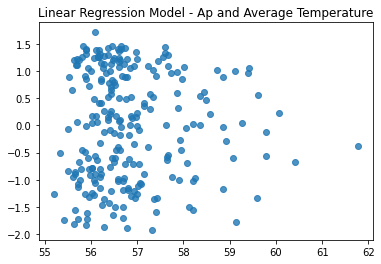

In [88]:
fig, ax = plt.subplots()
ax = sns.regplot(x = resultsAvgTemp_Ap.fittedvalues, y=resultsAvgTemp_Ap.resid_pearson, fit_reg=False)
plt.title("Linear Regression Model - Ap and Average Temperature")
plt.show()

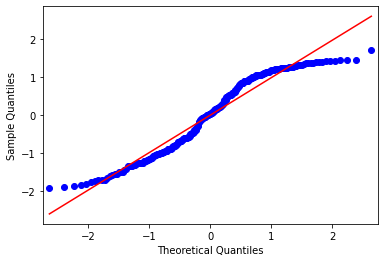

In [89]:
resid = resultsAvgTemp_Ap.resid_pearson.copy()
resid_std = stats.zscore(resid)
fig = statsmodels.graphics.gofplots.qqplot(resid, line='r')
plt.show()

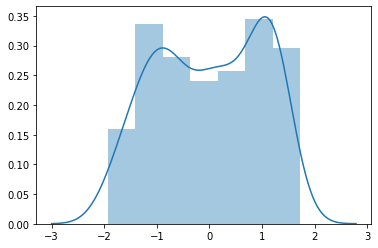

In [90]:
fig, ax = plt.subplots()
ax = sns.distplot(resid_std)
plt.show()

In [91]:
x = df.iloc[:,7:8].values
y = df.iloc[:, 14].values
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.33, random_state = 5)

lmTemp = LinearRegression()
lmTemp.fit(X_train, Y_train)
pred_train = lmTemp.predict(X_train)
pred_test = lmTemp.predict(X_test)

In [92]:
print("Fit a model X_train, and calculate MSE with Y_train:", np.mean((Y_train - lmTemp.predict(X_train))**2))

Fit a model X_train, and calculate MSE with Y_train: 223.09019344465014


In [93]:
print("Fit a model X_train and calculate MSE with X_test, Y_test:", np.mean((Y_test - lmTemp.predict(X_test))**2))

Fit a model X_train and calculate MSE with X_test, Y_test: 201.56089267109445


In [94]:
lmTemp.coef_

array([-0.01590417])

## Average Wind Speed

In [95]:
modelAvgWind_Ap = smf.ols(formula = 'AverageWindSpeed ~ ArithmeticAverageof8Ap', data = df)
resultsAvgWind_Ap = modelAvgWind_Ap.fit()
print(resultsAvgWind_Ap.summary())

                            OLS Regression Results                            
Dep. Variable:       AverageWindSpeed   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3907
Date:                Sun, 03 May 2020   Prob (F-statistic):              0.533
Time:                        17:41:06   Log-Likelihood:                -384.84
No. Observations:                 239   AIC:                             773.7
Df Residuals:                     237   BIC:                             780.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


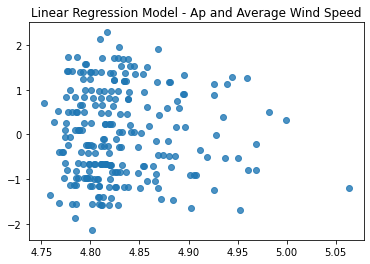

In [96]:
fig, ax = plt.subplots()
ax = sns.regplot(x = resultsAvgWind_Ap.fittedvalues, y=resultsAvgWind_Ap.resid_pearson, fit_reg=False)
plt.title("Linear Regression Model - Ap and Average Wind Speed")
plt.show()

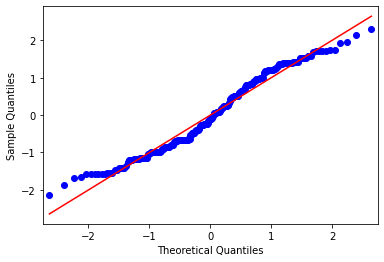

In [97]:
resid = resultsAvgWind_Ap.resid_pearson.copy()
resid_std = stats.zscore(resid)
fig = statsmodels.graphics.gofplots.qqplot(resid, line='r')
plt.show()

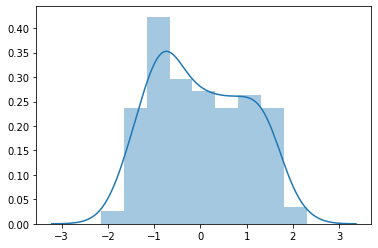

In [98]:
fig, ax = plt.subplots()
ax = sns.distplot(resid_std)
plt.show()

In [99]:
x = df.iloc[:,7:8].values
y = df.iloc[:, 12].values
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.33, random_state = 5)

lmWind = LinearRegression()
lmWind.fit(X_train, Y_train)
pred_train = lmWind.predict(X_train)
pred_test = lmWind.predict(X_test)

In [100]:
print("Fit a model X_train, and calculate MSE with Y_train:", np.mean((Y_train - lmWind.predict(X_train))**2))

Fit a model X_train, and calculate MSE with Y_train: 1.4704821539598103


In [101]:
print("Fit a model X_train and calculate MSE with X_test, Y_test:", np.mean((Y_test - lmWind.predict(X_test))**2))

Fit a model X_train and calculate MSE with X_test, Y_test: 1.3799602506031998


In [102]:
lmWind.coef_

array([0.00219473])

## Precipitation

In [103]:
modelPrecip_Ap = smf.ols(formula = 'Precipitation ~ ArithmeticAverageof8Ap', data = df)
resultsPrecip_Ap = modelPrecip_Ap.fit()
print(resultsPrecip_Ap.summary())

                            OLS Regression Results                            
Dep. Variable:          Precipitation   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9407
Date:                Sun, 03 May 2020   Prob (F-statistic):              0.333
Time:                        17:41:12   Log-Likelihood:                -518.58
No. Observations:                 239   AIC:                             1041.
Df Residuals:                     237   BIC:                             1048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

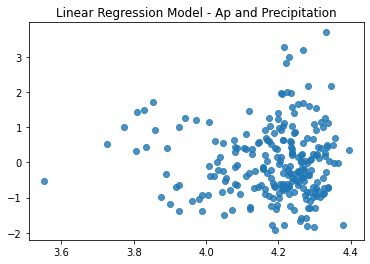

In [104]:
fig, ax = plt.subplots()
ax = sns.regplot(x = resultsPrecip_Ap.fittedvalues, y=resultsPrecip_Ap.resid_pearson, fit_reg=False)
plt.title("Linear Regression Model - Ap and Precipitation")
plt.show()

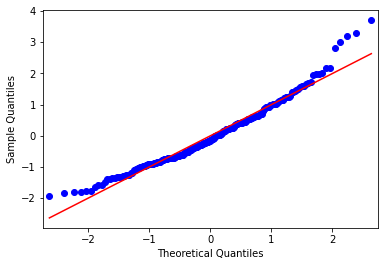

In [105]:
resid = resultsPrecip_Ap.resid_pearson.copy()
resid_std = stats.zscore(resid)
fig = statsmodels.graphics.gofplots.qqplot(resid, line='r')
plt.show()

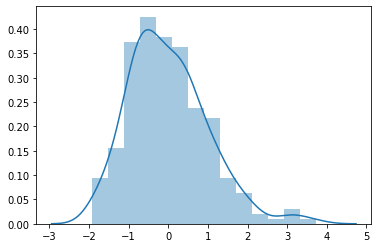

In [106]:
fig, ax = plt.subplots()
ax = sns.distplot(resid_std)
plt.show()

In [107]:
x = df.iloc[:,7:8].values
y = df.iloc[:, 13].values
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.33, random_state = 5)

lmPrecip = LinearRegression()
lmPrecip.fit(X_train, Y_train)
pred_train = lmPrecip.predict(X_train)
pred_test = lmPrecip.predict(X_test)

In [108]:
print("Fit a model X_train, and calculate MSE with Y_train:", np.mean((Y_train - lmPrecip.predict(X_train))**2))

Fit a model X_train, and calculate MSE with Y_train: 5.02121813888928


In [109]:
print("Fit a model X_train and calculate MSE with X_test, Y_test:", np.mean((Y_test - lmPrecip.predict(X_test))**2))

Fit a model X_train and calculate MSE with X_test, Y_test: 3.537070963850381


In [110]:
lmPrecip.coef_

array([-0.0072713])

# Random Forest Regression

## Average Temperature

In [111]:
df = df.dropna()
x = df.iloc[:,7:8].values
y = df.iloc[:, 14].values
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(x,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

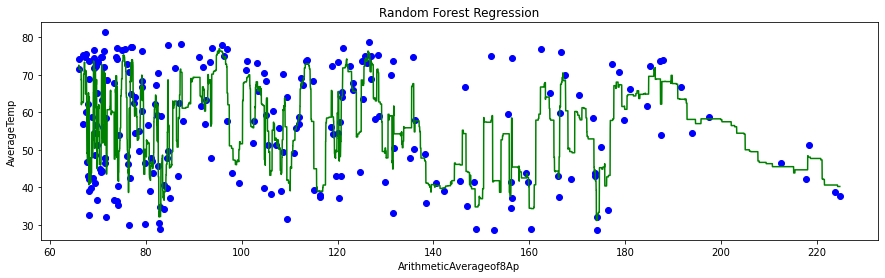

In [112]:
X_grid = np.arange(min(x), max(x), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(x,y,color = 'blue')
plt.plot(X_grid, regressor.predict(X_grid), color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('ArithmeticAverageof8Ap')
plt.ylabel('AverageTemp')
plt.show()

## Average Wind Speed

In [113]:
df = df.dropna()
x = df.iloc[:,7:8].values
y = df.iloc[:, 12].values
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(x,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

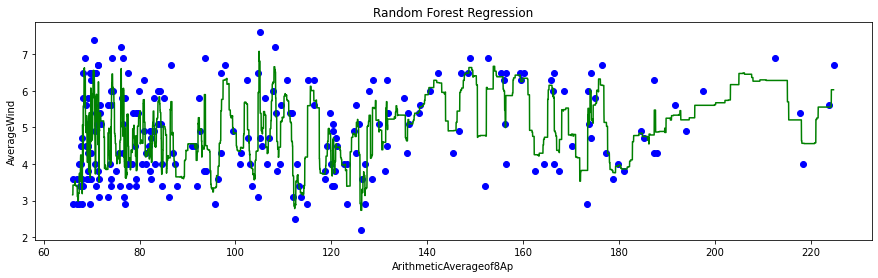

In [114]:
X_grid = np.arange(min(x), max(x), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(x,y,color = 'blue')
plt.plot(X_grid, regressor.predict(X_grid), color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('ArithmeticAverageof8Ap')
plt.ylabel('AverageWind')
plt.show()

## Precipitation

In [115]:
df = df.dropna()
x = df.iloc[:,7:8].values
y = df.iloc[:, 13].values
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(x,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

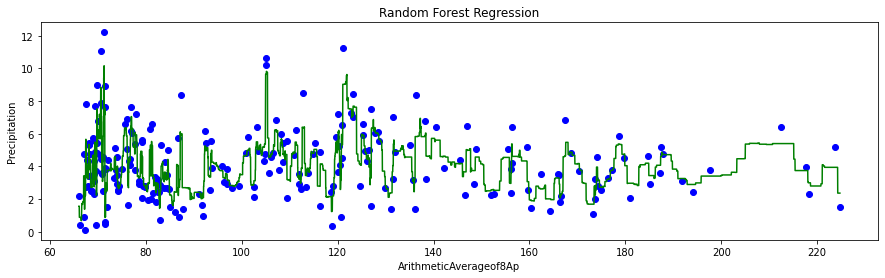

In [116]:
X_grid = np.arange(min(x), max(x), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(x,y,color = 'blue')
plt.plot(X_grid, regressor.predict(X_grid), color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('ArithmeticAverageof8Ap')
plt.ylabel('Precipitation')
plt.show()

# Support Vector Machine 

## Average Temperature

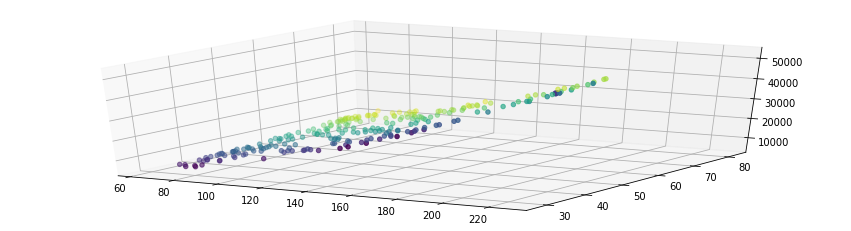

In [117]:
x = df.iloc[:,7:8].values
y = df.iloc[:, 14].values
x = x.reshape((-1, 1))
y = y.reshape((-1, 1))
z = (x**2 + y**2)
X = np.hstack((x, z))

fig = plt.figure()
axes = fig.add_subplot(111, projection = '3d')
axes.scatter(x, y, x**2 + y**2, c = y, depthshade = True)
plt.show()

## Average Wind Speed 

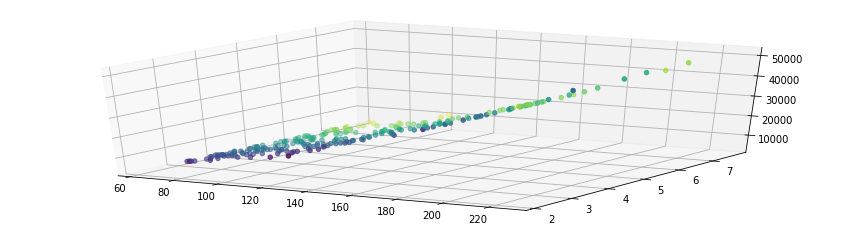

In [118]:
x = df.iloc[:,7:8].values
y = df.iloc[:, 12].values
x = x.reshape((-1, 1))
y = y.reshape((-1, 1))
z = (x**2 + y**2)
X = np.hstack((x, z))

fig = plt.figure()
axes = fig.add_subplot(111, projection = '3d')
axes.scatter(x, y, x**2 + y**2, c = y, depthshade = True)
plt.show()

## Precipitation

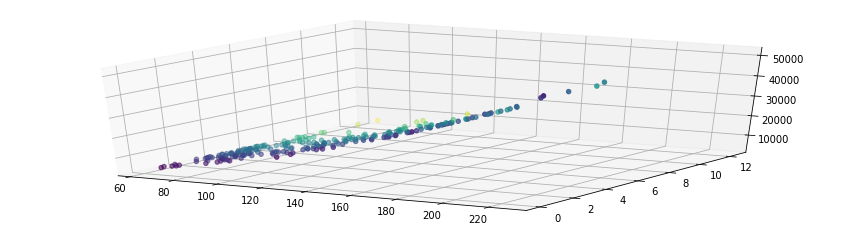

In [119]:
x = df.iloc[:,7:8].values
y = df.iloc[:, 13].values
x = x.reshape((-1, 1))
y = y.reshape((-1, 1))
z = (x**2 + y**2)
X = np.hstack((x, z))

fig = plt.figure()
axes = fig.add_subplot(111, projection = '3d')
axes.scatter(x, y, x**2 + y**2, c = y, depthshade = True)
plt.show()